In [2]:
import tensorflow as tf
import numpy as np

In [6]:
a = tf.zeros((3, 4))
a.dtype == np.float32

True

# `numpy...` $\to$ `tensorflow`  

In [10]:
tf.convert_to_tensor([3, 4, 5])

<tf.Tensor 'Const:0' shape=(3,) dtype=int32>

In [11]:
tf.convert_to_tensor(np.array([3, 4, 5, 6]))

<tf.Tensor 'Const_1:0' shape=(4,) dtype=int32>

In [12]:
tf.convert_to_tensor(a)

<tf.Tensor 'zeros_2:0' shape=(3, 4) dtype=float32>

# 求导

## [梯度计算：tf.gradients](https://www.w3cschool.cn/tensorflow_python/tensorflow_python-kbev2ezc.html)
`ys` 和 `xs` 是一个张量或一个张量的列表。`grad_ys` 是一个张量列表，持有由 `ys` 接收的梯度。该列表必须与 `ys` 具有相同长度。

要注意的是，`xs`中的`x`必须要与`ys`相关，不相关的话，会报错。 

错误的例子：
代码中定义了两个变量 `w1`， `w2`， 但`res`只与`w1`相关
```py
import tensorflow as tf

w1 = tf.Variable([[1, 2]])
w2 = tf.Variable([[3, 4]])

res = tf.matmul(w1, [[2], [1]])

grads = tf.gradients(res, [w1, w2])

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    re = sess.run(grads)
    print(re)
```

错误信息 
```sh
TypeError: Fetch argument None has invalid type 
```

正确的姿势：

In [39]:
import tensorflow as tf

w1 = tf.Variable([[1, 2]])
w2 = tf.Variable([[3, 4]])

res = tf.matmul(w1, [[2], [1]])

grads = tf.gradients(res, [w1]) 

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    re = sess.run(grads)
    print(re)

[array([[2, 1]])]


`gradients()` 向图形添加操作以输出 $\frac{\partial ys}{\partial xs}$ 。

- `ys`：要区分的张量或者张量列表。
- `xs`：用于微分的张量或者张量列表。
- `grad_ys`：（可选）与 `ys` 具有相同大小的张量或张量列表，并且对 `ys` 中的每个 `y` 计算的梯度。
- `name`：用于将所有渐变操作组合在一起的可选名称。默认为 “渐变”。
- `colocate_gradients_with_ops`：如果为 True，请尝试使用相应的操作对齐梯度。
- `gate_gradients`：如果为True，则在操作返回的梯度周围添加一个元组。这避免了一些竞态条件。 
- `aggregation_method`：指定用于组合渐变项的方法。接受的值是在类 `AggregationMethod` 中定义的常量。

返回值：
该函数返回 `xs` 中每个 x 的 `sum(dy/dx)` 的列表

可能引发的异常：
```py
LookupError：如果 x 和 y 之间的一个操作是没有注册的梯度函数。
ValueError：如果参数无效。
```

`grad_ys` 是与 `ys` 相同长度的张量列表，它包含 `y` 的初始梯度。当 `grad_ys` 是 `None` 时，我们在 `ys` 中为每个 `y` 填入一个 `1` 的形状的张量。用户可以提供自己的初始 `grad_ys`，使用不同的初始梯度为每个 `y` 计算导数 (例如：如果你想为每个 `y` 中的每个值不同地加权梯度)。

对于`grad_ys`的测试：

In [1]:
import tensorflow as tf

w1 = tf.get_variable('w1', shape=[3])
w2 = tf.get_variable('w2', shape=[3])

w3 = tf.get_variable('w3', shape=[3])
w4 = tf.get_variable('w4', shape=[3])

z1 = w1 + w2 + w3
z2 = w3 + w4

grads = tf.gradients(
    [z1, z2], [w1, w2, w3, w4],
    grad_ys=[
        tf.convert_to_tensor([2., 2., 3.]),
        tf.convert_to_tensor([3., 2., 4.])
    ])

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print(sess.run(grads))

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[array([2., 2., 3.], dtype=float32), array([2., 2., 3.], dtype=float32), array([5., 4., 7.], dtype=float32), array([3., 2., 4.], dtype=float32)]


In [90]:
w = tf.constant([[1., 2.], [3, 4]])
y = 2 * w 
z = y * w
f = z + w
g = tf.gradients([f, z], [w])
type(g)

list

In [91]:
with tf.Session() as sess:
    acc = tf.equal(g[0], 8 * w + 1)
    print(sess.run(acc))

[[ True  True]
 [ True  True]]


In [92]:
with tf.Session() as sess:
    print(sess.run(g))

[array([[ 9., 17.],
       [25., 33.]], dtype=float32)]


In [101]:
lr = 0.01
def opt(w, lr):
    for dw in g:
        w -= lr * dw
    return w

w = opt(w, lr)

In [102]:
with tf.Session() as sess:
    print(sess.run(w))

[[0.82000005 1.6600001 ]
 [2.5        3.3400002 ]]


## `tf.stop_gradient` 阻挡节点 `BP` 的梯度

使用`stop_gradient`函数，其输出值与输入相同，但不会参与反向传播中的梯度计算。

In [19]:
import tensorflow as tf

w1 = tf.Variable(2.0)
w2 = tf.Variable(2.0)

a = tf.multiply(w1, 3.0)
a_stoped = tf.stop_gradient(a)

# b=w1*3.0*w2
b = tf.multiply(a_stoped, w2)
gradients = tf.gradients(b, xs=[w1, w2])
print(gradients)

[None, <tf.Tensor 'gradients_3/Mul_1_grad/Mul_1:0' shape=() dtype=float32>]


可见，一个节点被 `stop` 之后，这个节点上的梯度，就无法再向前 `BP` 了。由于 `w1` 变量的梯度只能来自 `a` 节点，所以，计算梯度返回的是 `None`。

In [105]:
a = tf.Variable(1.0)
b = tf.Variable(1.0)

c = tf.add(a, b)

c_stoped = tf.stop_gradient(c)

d = tf.add(a, b)

e = tf.add(c_stoped, d)

gradients = tf.gradients(e, xs=[a, b])

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print(sess.run(gradients))

[1.0, 1.0]


虽然 `c` 节点被 stop 了，但是 `a`，`b` 还有从 `d` 传回的梯度，所以还是可以输出梯度值的。

In [106]:
import tensorflow as tf

w1 = tf.Variable(2.0)
w2 = tf.Variable(2.0)
a = tf.multiply(w1, 3.0)
a_stoped = tf.stop_gradient(a)

# b=w1*3.0*w2
b = tf.multiply(a_stoped, w2)

opt = tf.train.GradientDescentOptimizer(0.1)

gradients = tf.gradients(b, xs=tf.trainable_variables())

tf.summary.histogram(gradients[0].name, gradients[0])  # 这里会报错，因为 gradients[0] 是 None
#其它地方都会运行正常，无论是梯度的计算还是变量的更新。总觉着tensorflow这么设计有点不好，

AttributeError: 'NoneType' object has no attribute 'name'

In [107]:
#不如改成流过去的梯度为0
train_op = opt.apply_gradients(zip(gradients, tf.trainable_variables()))

print(gradients)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print(sess.run(train_op))
    print(sess.run([w1, w2]))

[None, None, None, None, None, None, None, None, <tf.Tensor 'gradients_29/Mul_1_grad/Mul_1:0' shape=() dtype=float32>]
None
[2.0, 1.4]


## 高阶导数
tensorflow 求**高阶导数**可以使用 `tf.gradients` 来实现：

In [108]:
import tensorflow as tf

with tf.device('/cpu:0'):
    a = tf.constant(1.)
    b = tf.pow(a, 2)
    grad = tf.gradients(ys=b, xs=a)  # 一阶导
    print(grad[0])
    grad_2 = tf.gradients(ys=grad[0], xs=a)  # 二阶导
    grad_3 = tf.gradients(ys=grad_2[0], xs=a)  # 三阶导
    print(grad_3)

with tf.Session() as sess:
    print(sess.run(grad_3))

Tensor("gradients_30/Pow_grad/Reshape:0", shape=(), dtype=float32, device=/device:CPU:0)
[<tf.Tensor 'gradients_32/gradients_31/gradients_30/Pow_grad/Pow_grad/Pow_grad/Reshape:0' shape=() dtype=float32>]
[0.0]


Note: 有些 `op`，`tf` 没有实现其高阶导的计算，例如 `tf.add` …, 如果计算了一个没有实现 高阶导的 `op` 的高阶导， `gradients` 会返回 `None`。

## `compute_gradients` 计算导数

```py
# Create an optimizer.optimizer必须和variable在一个设备上声明
opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)

# Compute the gradients for a list of variables.
grads_and_vars = opt.compute_gradients(loss, <list of variables>)

# grads_and_vars is a list of tuples (gradient, variable).  Do whatever you
# need to the 'gradient' part, for example cap them, etc.
capped_grads_and_vars = [(MyCapper(gv[0]), gv[1]) for gv in grads_and_vars]

# Ask the optimizer to apply the capped gradients.
opt.apply_gradients(capped_grads_and_vars)
```
或者

```py
#return a list of trainable variable in you model
params = tf.trainable_variables()

#create an optimizer
opt = tf.train.GradientDescentOptimizer(self.learning_rate)

#compute gradients for params
gradients = tf.gradients(loss, params)

#process gradients
clipped_gradients, norm = tf.clip_by_global_norm(gradients,max_gradient_norm)

train_op = opt.apply_gradients(zip(clipped_gradients, params))
```

这时, `sess.run(train_op)` 就可以进行训练了。

## `tf.clip_by_norm` 

[梯度爆炸的解决办法：clip gradient](https://blog.csdn.net/u010814042/article/details/76154391)

对梯度进行裁剪，通过控制梯度的最大范式，防止梯度爆炸的问题，是一种比较常用的梯度规约的方式。
```py
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.5)
grads = optimizer.compute_gradients(cost)
for i, (g, v) in enumerate(grads):
    if g is not None:
        grads[i] = (tf.clip_by_norm(g, 5), v)  # clip gradients
train_op = optimizer.apply_gradients(grads)
```

通过源码可以清晰的明白其作用在于将传入的梯度张量`t`的 L2 范数进行了上限约束，约束值即为 `clip_norm`，如果`t`的 L2 范数超过了 `clip_norm`，则变换为`t * clip_norm / l2norm(t)`，如此一来，变换后的`t`的 L2 范数便小于等于`clip_norm`了。

In [27]:
import numpy as np
t = np.random.randint(low=0, high=7, size=10)
t

array([0, 0, 0, 2, 0, 2, 3, 0, 3, 4])

In [28]:
l2norm4t = np.linalg.norm(t) # 计算 L2 范数
l2norm4t

6.48074069840786

In [29]:
# 随机数规约
clip_norm = 7
transformed_t = t * clip_norm / l2norm4t
transformed_t

array([0.        , 0.        , 0.        , 2.1602469 , 0.        ,
       2.1602469 , 3.24037035, 0.        , 3.24037035, 4.3204938 ])

In [30]:
# 验证
np.linalg.norm(transformed_t)

6.999999999999999

## `tf.clip_by_value(A, min, max)`

输入一个张量`A`，把`A`中的每一个元素的值都压缩在`min`和`max`之间。小于`min`的让它等于`min`，大于`max`的元素的值等于`max`。

In [32]:
import tensorflow as tf
import numpy as np

A = np.array([[1, 1, 2, 4], [3, 4, 8, 5]])

with tf.Session() as sess:
    print(sess.run(tf.clip_by_value(A, 2, 5)))

[[2 2 2 4]
 [3 4 5 5]]


## [Tensorflow的梯度异步更新](https://blog.csdn.net/supe_king/article/details/78017429)
## [Tensorflow一些常用基本概念与函数（4）](https://blog.csdn.net/lenbow/article/details/52218551)
## [利用 tf.gradients 在 TensorFlow 中实现梯度下降](https://segmentfault.com/a/1190000012531967)
## [『TensorFlow』梯度优化相关 ](http://www.cnblogs.com/hellcat/p/7435977.html)

# `tf.train`（优化算法）

**`tf` 下以大写字母开头的含义为名词的一般表示一个类（`class`）**。

## 优化器（optimizer）
优化器的基类（Optimizer base class）主要实现了两个接口，一是计算损失函数的梯度，二是将梯度作用于变量。
```py
tf.train.Optimizer
tf.train.GradientDescentOptimizer
tf.train.AdadeltaOpzimizer 
tf.train.AdagradDAOptimizer
tf.train.MomentumOptimizer
tf.train.AdamOptimizer
tf.train.FtrlOptimizer
tf.train.ProximalGradientDescentOptimizer
tf.train.ProximalAdagradOptimizer
tf.train.RMSPropOptimizer
```

## 梯度计算

TensorFlow 同时也提供了给定 TensorFlow 计算图（computation graph）的导数。优化器类（optimizer classes）会自动计算 computation graph 的导数，但用户自定义优化器时，可以使用如下低级别的函数：
```py
tf.gradients
tf.AggregationMethod
tf.stop_gradient
tf.hessians
```

## 学习率衰减（decaying the learning rate）
`tf.train.exponential_decay`
实现的是如下的操作:
$$decayedlr = lr \times decayrate^{\frac{globalstep}{decaysteps}}$$

```py
lr = tf.train.exponential_decay(0.1, global_step, 100, .96, staircase=True)
```

还有其他的
```py
tf.train.inverse_time_decay
tf.train.natural_exp_decay
tf.train.piecewise_constant
tf.train.polynomial_decay
```

# [权值更新](https://blog.csdn.net/GH234505/article/details/54976696)



# [分布式Tensorflow的梯度累积与异步更新](https://zhuanlan.zhihu.com/p/23060519)

# tensorflow 如何自由处理梯度

一个优化器：`optm = tf.train.AdamOptimizer(learning_rate).minimize(loss) `
 `minimize` 可看作 `compute_gradients` 和 `apply_gradients` 二者之和，即计算和更新梯度;另一种更新方式就是先计算梯度，再更新我们需要更新的变量。
 
如下，第一种方式，一步计算：
```py
t_vars = tf.trainable_variables() #获取所有变量名  
G_vars=[var for var in t_vars if 'generator' in var.name] #获取需要的变量名  
g_optm = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(g_loss,var_list=G_vars) 
```

第二种方式，分步计算：
```py
t_vars = tf.trainable_variables()  
G_vars=[var for var in t_vars if 'generator' in var.name]  
gradient_all =tf.train.GradientDescentOptimizer(0.01).compute_gradients(loss,var_list=G_vars) #对应变量名的梯度计算,这是第一步  
optm = tf.train.GradientDescentOptimizer(0.01).apply_gradients(gradient_all) #更新计算出来的梯度，这是第二步  
```
另外，还有两个函数，不常用到，了解一下即可：
`tf.gradients(ys, xs, grad_ys=None, name=’gradients’, colocate_gradients_with_ops=False, gate_gradients=False, aggregation_method=None)` 
该函数计算`ys`在`xs`方向上的梯度，需要注意与`train.compute_gradients`所不同的地方是，该函数返回一组`dy/dx`的列表，而不是梯度-权值对；
`tf.stop_gradient(input, name=None)`该函数告知整个 graph 图中，对 input 不进行梯度计算，将其伪装成一个 constant 常量。

下面还有一些其他的技巧：
- `gradient_all = optimizer.compute_gradients(loss)` 计算全部 gradient 
- `grads_vars = [v for (g,v) in gradient_all if g is not None]`  得到可进行梯度计算的变量
- `gradient = optimizer.compute_gradients(loss, grads_vars)` 得到所需梯度
- `grads_holder = [(tf.placeholder(tf.float32, shape=g.get_shape()), v) for (g,v) in gradient]` 生成holder 
- `train_op = optimizer.apply_gradients(grads_holder)` 继续进行 BP 算法
- `gradient_result = sess.run(gradient, feed_dict={x:x_i,y_:y_real})`生成结果，计算`loss`与`gradient`

```py
grads_dict={} 
for i in range(len(gradient_result)): 
  k = grads_holder[i][0] # 取出holder，用于后面的feed_dict 
  grads_dict[k] = DealTheGradientFunction(gradient_result[i][0]) # 自由处理梯度
```
继续更新权值：`_ = sess.run(train_op,feed_dict=grads_dict)`

# Tips
## glob
在linux下 `glob` 得到的列表是乱序的，需要用sort重新排序。windows 下 `glob` 的到的列表顺序和文件夹显示的顺序一致。由于这一错误导致我在Linux 下训练的模型在 windows 下测试，准确率为`0`的bug。

In [35]:
from glob import glob

## `tf.shape` 和 `get_shape` 的区别
- 相同点：都可以得到tensor `a`的尺寸
- 不同点：`tf.shape(a)` 中 `a` 数据的类型可以是 `tensor`, `list`, `array` 
  - `a.get_shape()` 中 `a` 的数据类型只能是 `tensor`,且返回的是一个元组（`tuple`）
  
另外，`a.get_shape()` 得到的`tuple`可以利用 `a.get_shape().as_list`  转成列表，从而对维度进行调用。 

## GPU 内存的使用
```py
with tf.device('/gpu:0'):  
```
可以使用这一条代码指定某段程序在某一个 GPU 上运算，但仍然会默认占用所有 GPU 资源。不过不和其他人公用 GPU 时也不会有影响，下面介绍两种限定GPU占用的方法：
- (1)在tensorflow中定义`session`时作如下设置，该设置会启用最少的 GPU 显存来运行程序：
```py
config = tf.ConfigProto()   
config.gpu_options.allow_growth = True   
session = tf.Session(config=config)
```
- (2)在tensorflow中定义`session`时作如下设置，该设置会强制程序只占用指定比例的 GPU 显存
```py
config = tf.ConfigProto()   
config.gpu_options.per_process_gpu_memory_fraction = 0.4 # 占用GPU40%的显存   
session = tf.Session(config=config)  
```

# 实例

## 线性模型

In [6]:
import sys

import tensorflow as tf
import numpy as np

sys.path.append('E:/xinlib')
import xin

In [27]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

X = tf.random_normal(shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * tf.random_normal(shape=y.shape)

Populating the interactive namespace from numpy and matplotlib


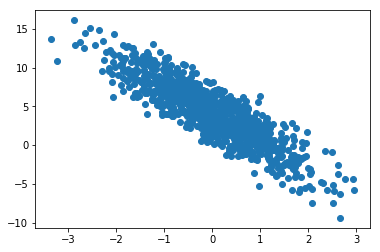

In [8]:
with tf.Session() as sess:
    x, y = sess.run([X[:, 1], y])
    
%pylab inline 
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.show()

## 读取数据

In [16]:
batch_size = 8

# `tf.data`

[Introduction to TensorFlow Datasets and Estimators ](https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html)

# `tf.feature_column`
[Introducing TensorFlow Feature Columns](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html)

# [实践指南！16位资深行业者教你如何学习使用TensorFlow](https://yq.aliyun.com/articles/71257?spm=a2c4e.11153940.blogcont159607.7.3631c0d0PvdaZt)

# [一步步带你探究如何高效使用TensorFlow](https://yq.aliyun.com/articles/159607)

In [31]:
import numpy as np
x = np.random.normal(size=[10, 10])
y = np.random.normal(size=[10, 10])
z = np.dot(x, y)
print(z)

[[  1.03331374   6.19707923  -2.65490643  -3.11765891  -3.00808424
    2.33188916  -0.28865182   0.05087656  -1.34591431  -0.54639253]
 [  3.67046851  -2.91739165   4.75408801   2.09665533  -5.55064586
   -0.46559925   2.82975126  -2.98270113  -0.02802994  -0.93889597]
 [ -1.78899577   1.920233    -0.41724299  -2.20148806   1.00424694
    3.85985832  -0.76609938  -0.65608963   6.31061359  -3.52004825]
 [  0.31710265   1.22672474   0.25260203  -3.24767086   2.36133336
    3.01376792  -2.66408039  -0.31694837  -2.25025004   3.43554427]
 [  0.61614322  -0.45212473  -1.36364379  -0.44071573   2.0418642
    3.51081078  -1.40006173   3.52076313   4.9593532    4.88758445]
 [ -0.78130895   0.65931508  -0.53749482   0.4980627   -1.10368293
   -4.50019785   2.05422741   2.22937077   0.45502323  -2.75807115]
 [ -5.24531503   0.82081194   1.5217025   -2.21103868  -5.20085584
    4.10433908  -1.85932076  -0.49930007   1.52608001  -4.52715066]
 [ -1.67055655  -1.13645355   0.87097301  -3.21453496   

In [32]:
import tensorflow as tf
x = tf.random_normal([10, 10])
y = tf.random_normal([10, 10])
z = tf.matmul(x, y)
sess = tf.Session()
z_val = sess.run(z)
print(z_val)

[[-6.0421467  -4.002712   -3.4028344   5.4274063  -3.2356334  -1.8574154
  -0.28259626 -4.578471    0.7213292   3.9324884 ]
 [-0.47098017  2.2730732   6.550978    2.4557724  -0.45082462 -0.22762877
  -5.4430184   1.5002248   4.0452495   7.0937047 ]
 [-1.0261753   1.729397    1.9933732  -4.360579    1.6377666   4.4436703
  -0.13812351  6.3661013  -0.23438215 -0.2771334 ]
 [ 4.910007   -3.0467596  -4.930425   -1.1172944   0.03339058 -4.2460065
  -1.9423164  -2.6526754  -1.4606994  -1.095494  ]
 [ 1.3435711   3.993326    1.5301259  -1.1121674   1.9628985   1.8056077
   2.4359083   2.3335717  -1.0083514  -1.0688686 ]
 [ 5.6436744  -3.4744835  -4.8716187   1.5645031  -0.2647297  -6.4770794
  -4.1336164  -4.3394995  -1.2156465  -1.0004427 ]
 [ 2.299832    1.4956679   4.046055   -0.40779734  5.0517254   4.0086474
   1.670546    0.6349054   2.3316076  -1.6516174 ]
 [-0.94313014  0.75890946 -0.24313027  0.4651425  -0.63462377 -0.32604343
  -3.5050843   2.5974834   0.9161282   4.0798054 ]
 [ 0.3

In [33]:
import numpy as np
import tensorflow as tf
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
w = tf.get_variable("w", shape=[3, 1])
f = tf.stack([tf.square(x), x, tf.ones_like(x)], 1)
yhat = tf.squeeze(tf.matmul(f, w), 1)
loss = tf.nn.l2_loss(yhat - y) + 0.1 * tf.nn.l2_loss(w)
train_op = tf.train.AdamOptimizer(0.1).minimize(loss)


def generate_data():
    x_val = np.random.uniform(-10.0, 10.0, size=100)
    y_val = 5 * np.square(x_val) + 3
    return x_val, y_val


sess = tf.Session()
sess.run(tf.global_variables_initializer())
for _ in range(1000):
    x_val, y_val = generate_data()
    _, loss_val = sess.run([train_op, loss], {x: x_val, y: y_val})
    print(loss_val)
print(sess.run([w]))

3143759.0
3740112.0
3608657.2
2515516.2
3038907.2
2588791.2
3119756.2
2549852.5
2220376.8
2708472.8
2576062.2
2492518.8
2039833.5
2259819.8
1931321.6
1719102.9
1973012.9
1594744.6
2184101.2
1594456.0
1207074.1
1303249.9
1355927.6
1094771.4
1321905.6
866927.75
1350942.4
864273.25
1183633.6
1047666.4
934974.0
930504.25
928699.5
655231.7
596410.75
721939.3
491044.12
450454.44
555685.44
406265.7
538209.75
560216.94
473007.94
404060.7
409225.88
376299.88
329518.12
306558.75
325387.84
270446.4
223664.11
222827.56
217542.27
216481.9
209596.64
173116.69
155292.44
137046.23
115506.29
104236.29
99822.266
91211.25
122778.27
74970.766
59496.613
64921.918
59790.38
51396.11
53644.49
46372.645
45027.742
36598.766
31598.027
32428.33
28968.773
21590.38
23217.35
19578.488
19203.758
12056.286
13305.461
12619.753
9759.518
9880.029
8764.966
6232.3887
6538.0015
4720.905
4752.2524
3011.5452
3251.0444
4056.34
2465.4026
2212.9578
1682.897
1252.2856
1432.9865
1072.9551
684.302
635.0142
603.1076
485.29834
445.19

17.270063
17.713366
19.926014
18.140945
20.88477
17.564611
16.631016
17.42385
17.522978
19.754852
19.021847
18.781872
15.904143
18.549677
16.132143
17.527224
17.073736
16.739182
14.486741
17.275696
16.414764
17.973736
18.638836
17.293047
15.548361
17.09206
18.162504
18.703545
16.383549
15.702926
15.312151
16.297485
15.723501
17.451061
18.196142
16.266468
17.886166
15.444521
18.545992
14.388419
17.83402
15.825032
17.309952
16.084635
14.718386
17.588358
16.438162
16.0892
14.528255
16.732674
16.169094
13.926801
16.269701
15.13307
15.692302
14.934718
16.534472
14.817079
15.817457
[array([[4.9875326e+00],
       [1.2238083e-03],
       [3.7676127e+00]], dtype=float32)]


## 理解静态形状和动态形状的区别：

Tensorflow 中的张量在图形构造期间具有静态的形状属性。例如，我们可以定义一个形状的张量`[None，128]`：

In [36]:
import tensorflow as tf
a = tf.placeholder(tf.float32, [None, 128])

In [38]:
static_shape = a.get_shape().as_list()  # returns [None, 128]
static_shape

[None, 128]

为了获得张量的动态形状，你可以调用 `tf.shape` op，它将返回一个表示给定形状的张量：

In [40]:
dynamic_shape = tf.shape(a)
dynamic_shape

<tf.Tensor 'Shape_1:0' shape=(2,) dtype=int32>

我们可以使用 `Tensor.set_shape` 方法设置张量的静态形状：

In [42]:
a.set_shape([32, 128])

实际上使用 `tf.reshape` 操作更为安全：

In [43]:
a =  tf.reshape(a, [32, 128])

这里有一个函数可以方便地返回静态形状，当静态可用而动态不可用的时候。

In [44]:
def get_shape(tensor):
    static_shape = tensor.get_shape().as_list()
    dynamic_shape = tf.unstack(tf.shape(tensor))
    dims = [s[1] if s[0] is None else s[0]
            for s in zip(static_shape, dynamic_shape)]
    return dims

现在想象一下，如果我们要将三维的张量转换成二维的张量。在 TensorFlow 中我们可以使用 `get_shape` m函数：

In [83]:
if a.dtype.char in np.typecodes['AllFloat']:

In [84]:
b = tf.random_normal([10, 32, 32, 3])
shape = TensorShape(b)

In [85]:
b_ = shape.get_shape()

In [86]:
b_

[10, 32, 32, 3]

In [2]:
import tensorflow as tf
a = tf.constant([[1., 2.], [3., 4.]])
b = tf.constant([[1.], [2.]])

c = a + b 

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
x = tf.random_normal([10])
y = tf.nn.relu(x * x)
with tf.Session():
    diff = tf.test.compute_gradient_error(x, [10], y, [10])
    print(diff)

4.220008850097656e-05
